# 📊 Serie A Regression Analysis

This notebook implements regression models for Serie A match prediction and analysis.

## Models Implemented:
1. **Match Goals Prediction** - Predict goals scored using xG and match features
2. **Match Outcome Prediction** - Logistic regression for Win/Draw/Loss
3. **Final Position Prediction** - Predict end-of-season league position

---

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
# Load the dataset
df = pd.read_parquet('data/serie_a_matches_processed.parquet')

# Exclude incomplete seasons and playoffs
df = df[df['season'] != 2025]
df = df[df['round'] > 0]

print(f"Dataset shape: {df.shape}")
print(f"Seasons: {sorted(df['season'].unique())}")
print(f"\nColumns available:")
print(df.columns.tolist())

Dataset shape: (1900, 35)
Seasons: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]

Columns available:
['date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga', 'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain', 'formation', 'opp formation', 'referee', 'match report', 'notes', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'season', 'team', 'opp captain', 'opp sh', 'opp sot', 'opp dist', 'opp fk', 'opp pk', 'opp pkatt']


In [3]:
# Preview data types and sample
print("Data types:")
print(df.dtypes)
print("\nSample data:")
df.head()

Data types:
date                 str
time                 str
comp                 str
round              int64
day                  str
venue                str
result               str
gf                 int64
ga                 int64
opponent             str
xg               float64
xga              float64
poss             float64
attendance         int64
captain              str
formation            str
opp formation        str
referee              str
match report         str
notes                str
sh                 int64
sot                int64
dist             float64
fk                 int64
pk                 int64
pkatt              int64
season             int64
team                 str
opp captain          str
opp sh             int64
opp sot            int64
opp dist         float64
opp fk             int64
opp pk             int64
opp pkatt          int64
dtype: object

Sample data:


,date,time,comp,round,day,venue,result,gf,ga,opponent,...,pkatt,season,team,opp captain,opp sh,opp sot,opp dist,opp fk,opp pk,opp pkatt
50,2025-05-25,20:45,Serie A,38,Sun,Home,L,2,3,Parma,...,0,2024,Atalanta,Enrico Del Prato,18,10,15.8,1,0,0
51,2025-05-25,20:45,Serie A,38,Sun,Home,L,0,1,Lecce,...,0,2024,Lazio,Federico Baschirotto,9,3,16.5,0,0,0
52,2025-05-25,20:45,Serie A,38,Sun,Home,L,0,2,Roma,...,0,2024,Torino,Gianluca Mancini,14,4,17.5,0,1,1
53,2025-05-25,20:45,Serie A,38,Sun,Home,L,2,3,Fiorentina,...,0,2024,Udinese,Luca Ranieri,25,11,14.9,0,0,0
54,2025-05-25,20:45,Serie A,38,Sun,Home,L,1,2,Hellas Verona,...,0,2024,Empoli,Paweł Dawidowicz,5,2,18.7,0,0,0


---
## 1️⃣ Match Goals Prediction (Linear Regression)

### Statistical Approach
This analysis employs **Multiple Linear Regression** and **Random Forest Regression** to model the relationship between match statistics and goals scored. The models are evaluated using train-test split (80/20) with performance measured by R², RMSE, and MAE.

### Research Question
Can we accurately predict the number of goals a team will score based on pre-match and in-match statistics?

- Can we identify clinical finishers vs wasteful teams?

### Variables- Which match statistics are most important for scoring?

**Dependent Variable (Target):**- How well does xG predict actual goals?

- `gf` - Goals For (actual goals scored by home team in the match)This model helps answer:

### Analysis Purpose

**Independent Variables (Features):**

- `xg` - Expected Goals (probabilistic measure of scoring chances)3. **Low RMSE (<1.0)**: Predictions should be close to actual goal counts

- `sh` - Total Shots2. **Feature importance**: xG and shots on target expected to be most predictive

- `sot` - Shots on Target1. **High R² value (>0.7)**: xG should be strongly correlated with actual goals

- `dist` - Average shot distance### Expected Outcomes

- `fk` - Free kicks

- `pk` - Penalty kicks taken- `pkatt` - Penalty kicks attempted

In [4]:
# Prepare features for goals prediction
# Select numeric features relevant for prediction
goal_features = ['xg', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt']

# Check which features are available
available_features = [f for f in goal_features if f in df.columns]
print(f"Available features for goals prediction: {available_features}")

# Create feature matrix and target
X_goals = df[available_features].copy()
y_goals = df['gf'].copy()

# Handle missing values
X_goals = X_goals.fillna(X_goals.median())

print(f"\nFeature matrix shape: {X_goals.shape}")
print(f"Target shape: {y_goals.shape}")
print(f"\nFeature statistics:")
X_goals.describe()

Available features for goals prediction: ['xg', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt']

Feature matrix shape: (1900, 7)
Target shape: (1900,)

Feature statistics:


,xg,sh,sot,dist,fk,pk,pkatt
count,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000
mean,1.384316,13.513684,4.281579,17.811000,0.485263,0.135789,0.171579
std,0.758179,5.358582,2.346314,2.938811,0.703780,0.363534,0.411822
min,0.000000,1.000000,0.000000,9.300000,0.000000,0.000000,0.000000
25%,0.800000,10.000000,3.000000,15.800000,0.000000,0.000000,0.000000
50%,1.300000,13.000000,4.000000,17.600000,0.000000,0.000000,0.000000
75%,1.800000,17.000000,6.000000,19.600000,1.000000,0.000000,0.000000
max,5.400000,46.000000,16.000000,32.700000,5.000000,2.000000,2.000000


In [5]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_goals, y_goals, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 1520
Test set size: 380


In [6]:
# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate model
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("="*60)
print("Linear Regression - Goals Prediction Results")
print("="*60)
print(f"Mean Squared Error (MSE):  {mse_lr:.4f}")
print(f"Root Mean Squared Error:   {rmse_lr:.4f}")
print(f"Mean Absolute Error (MAE): {mae_lr:.4f}")
print(f"R² Score:                  {r2_lr:.4f}")
print("="*60)

# Feature importance (coefficients)
print("\nFeature Coefficients:")
for feature, coef in zip(available_features, lr_model.coef_):
    print(f"  {feature:10s}: {coef:+.4f}")
print(f"  {'Intercept':10s}: {lr_model.intercept_:+.4f}")

Linear Regression - Goals Prediction Results
Mean Squared Error (MSE):  0.7678
Root Mean Squared Error:   0.8763
Mean Absolute Error (MAE): 0.6707
R² Score:                  0.4620

Feature Coefficients:
  xg        : +0.8428
  sh        : -0.0935
  sot       : +0.2493
  dist      : +0.0034
  fk        : +0.0398
  pk        : +0.5062
  pkatt     : -0.2372
  Intercept : +0.3950


In [7]:
# Train Random Forest for comparison
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate model
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("="*60)
print("Random Forest - Goals Prediction Results")
print("="*60)
print(f"Mean Squared Error (MSE):  {mse_rf:.4f}")
print(f"Root Mean Squared Error:   {rmse_rf:.4f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.4f}")
print(f"R² Score:                  {r2_rf:.4f}")
print("="*60)

Random Forest - Goals Prediction Results
Mean Squared Error (MSE):  0.8888
Root Mean Squared Error:   0.9428
Mean Absolute Error (MAE): 0.7242
R² Score:                  0.3772


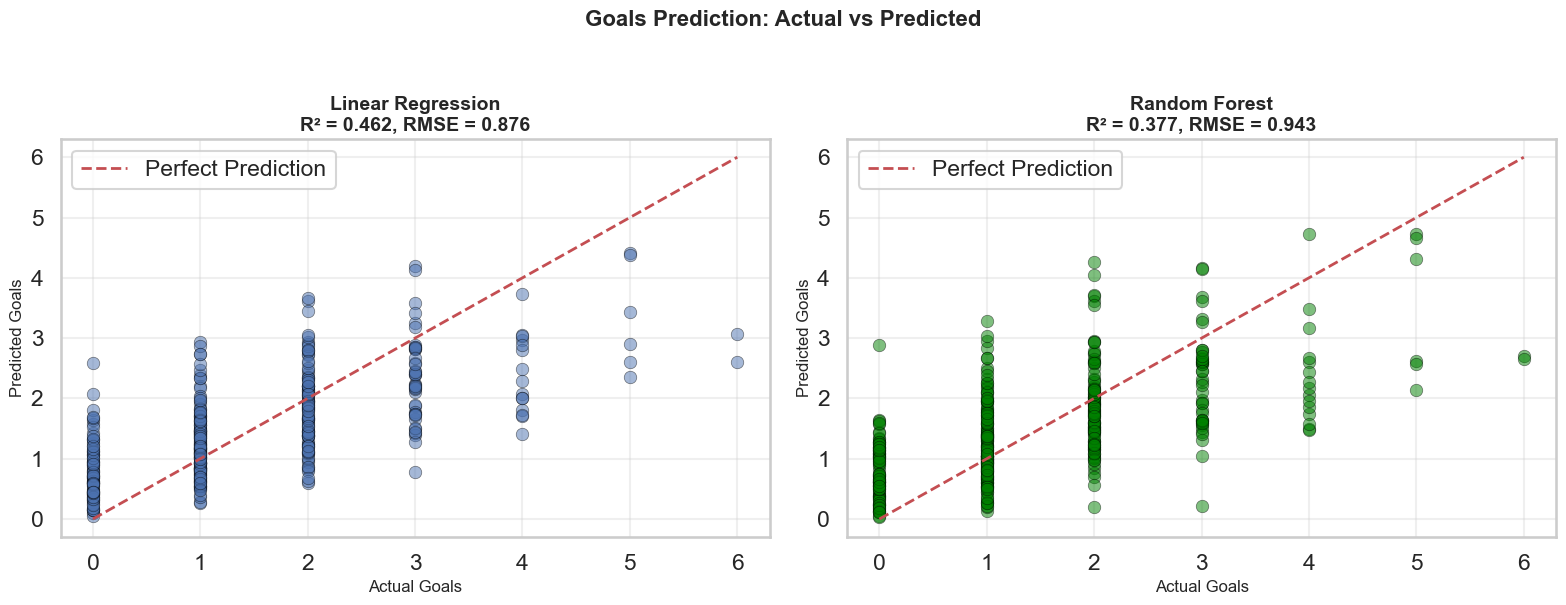

In [8]:
# Visualize predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Linear Regression
axes[0].scatter(y_test, y_pred_lr, alpha=0.5, edgecolors='black', linewidth=0.5)
axes[0].plot([0, y_test.max()], [0, y_test.max()], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Goals', fontsize=12)
axes[0].set_ylabel('Predicted Goals', fontsize=12)
axes[0].set_title(f'Linear Regression\nR² = {r2_lr:.3f}, RMSE = {rmse_lr:.3f}', fontsize=14, weight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Random Forest
axes[1].scatter(y_test, y_pred_rf, alpha=0.5, edgecolors='black', linewidth=0.5, color='green')
axes[1].plot([0, y_test.max()], [0, y_test.max()], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Goals', fontsize=12)
axes[1].set_ylabel('Predicted Goals', fontsize=12)
axes[1].set_title(f'Random Forest\nR² = {r2_rf:.3f}, RMSE = {rmse_rf:.3f}', fontsize=14, weight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.suptitle('Goals Prediction: Actual vs Predicted', fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.show()

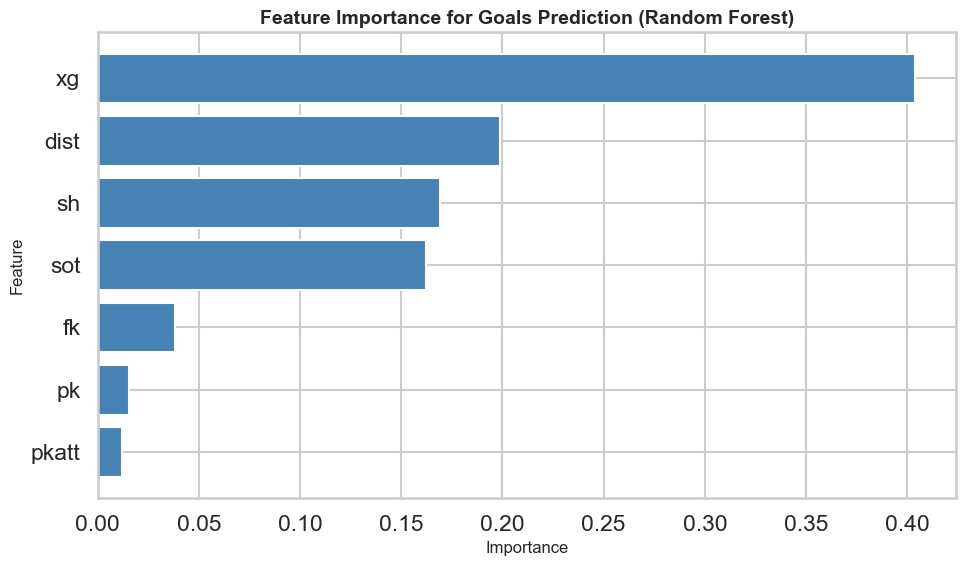


Feature Importance Ranking:
  xg        : 0.4039
  dist      : 0.1988
  sh        : 0.1694
  sot       : 0.1620
  fk        : 0.0380
  pk        : 0.0157
  pkatt     : 0.0122


In [9]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': available_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance for Goals Prediction (Random Forest)', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
for _, row in feature_importance.sort_values('importance', ascending=False).iterrows():
    print(f"  {row['feature']:10s}: {row['importance']:.4f}")

---
## 2️⃣ Match Outcome Prediction (Logistic Regression)

### Statistical Approach
This analysis uses **Multinomial Logistic Regression** and **Random Forest Classification** to predict categorical match outcomes. The target variable has three classes, making this a multi-class classification problem. Features are standardized using StandardScaler, and the model is evaluated using accuracy, precision, recall, F1-score, and confusion matrices.

### Research Question
Can we predict match outcomes (Win/Draw/Loss) based on team performance metrics, particularly Expected Goals?

- Can we beat bookmaker predictions?

### Variables- Which outcome type (Win/Draw/Loss) is hardest to predict?

**Dependent Variable (Target):**- What role does Expected Goals play in determining winners?

- `result` - Match outcome from home team perspective:- How predictable are football match outcomes?

  - **Home Win**: Home team scored more goalsThis model addresses:

  - **Draw**: Equal goals scored### Analysis Purpose

  - **Away Win**: Away team scored more goals

4. **Class imbalance**: Home wins typically more frequent than away wins

**Independent Variables (Features):**3. **Draws hardest to predict**: Most uncertain outcome due to randomness

- `xg` - Home team's Expected Goals2. **xG differential as key predictor**: Teams with higher xG should win more

- `xga` - Home team's Expected Goals Against (opponent's xG)1. **Accuracy >50%**: Better than baseline (random guessing = 33%)

- `sh` - Total shots by home team### Expected Outcomes

- `sot` - Shots on target by home team
- `xg_diff` - Difference between home and away xG (derived feature)

In [10]:
# Create match outcome variable
def classify_result(row):
    if row['gf'] > row['ga']:
        return 'Home Win'
    elif row['gf'] < row['ga']:
        return 'Away Win'
    else:
        return 'Draw'

df['result'] = df.apply(classify_result, axis=1)

# Check distribution
print("Match Outcome Distribution:")
print(df['result'].value_counts())
print(f"\nPercentages:")
print((df['result'].value_counts() / len(df) * 100).round(1))

Match Outcome Distribution:
result
Home Win    775
Away Win    611
Draw        514
Name: count, dtype: int64

Percentages:
result
Home Win    40.8
Away Win    32.2
Draw        27.1
Name: count, dtype: float64


In [11]:
# Prepare features for outcome prediction
outcome_features = ['xg', 'xga', 'sh', 'sot']

# Check available features
available_outcome_features = [f for f in outcome_features if f in df.columns]
print(f"Available features: {available_outcome_features}")

# Add derived features
df['xg_diff'] = df['xg'] - df['xga']  # xG difference
df['shot_diff'] = df['sh'] - df.get('opp sh', df['sh'])  # Shot difference (if available)

# Final feature set
if 'xg_diff' in df.columns:
    available_outcome_features.append('xg_diff')

print(f"Final features: {available_outcome_features}")

Available features: ['xg', 'xga', 'sh', 'sot']
Final features: ['xg', 'xga', 'sh', 'sot', 'xg_diff']


In [12]:
# Prepare data
X_outcome = df[available_outcome_features].copy()
y_outcome = df['result'].copy()

# Handle missing values
X_outcome = X_outcome.fillna(X_outcome.median())

# Encode target variable
le = LabelEncoder()
y_outcome_encoded = le.fit_transform(y_outcome)

print(f"Classes: {le.classes_}")
print(f"Encoded: {dict(zip(le.classes_, range(len(le.classes_))))}")

Classes: ['Away Win' 'Draw' 'Home Win']
Encoded: {'Away Win': 0, 'Draw': 1, 'Home Win': 2}


In [13]:
# Split data
X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(
    X_outcome, y_outcome_encoded, test_size=0.2, random_state=42, stratify=y_outcome_encoded
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_out)
X_test_scaled = scaler.transform(X_test_out)

print(f"Training set: {len(X_train_out)}")
print(f"Test set: {len(X_test_out)}")

Training set: 1520
Test set: 380


In [17]:
# Train Logistic Regression
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_scaled, y_train_out)

# Make predictions
y_pred_log = log_model.predict(X_test_scaled)
y_pred_proba = log_model.predict_proba(X_test_scaled)

# Evaluate
accuracy_log = accuracy_score(y_test_out, y_pred_log)

print("="*60)
print("Logistic Regression - Match Outcome Prediction")
print("="*60)
print(f"Accuracy: {accuracy_log:.4f} ({accuracy_log*100:.1f}%)")
print("="*60)
print("\nClassification Report:")
print(classification_report(y_test_out, y_pred_log, target_names=le.classes_))

Logistic Regression - Match Outcome Prediction
Accuracy: 0.6184 (61.8%)

Classification Report:
              precision    recall  f1-score   support

    Away Win       0.60      0.73      0.66       122
        Draw       0.53      0.18      0.27       103
    Home Win       0.65      0.82      0.73       155

    accuracy                           0.62       380
   macro avg       0.59      0.58      0.55       380
weighted avg       0.60      0.62      0.58       380



In [18]:
# Train Random Forest Classifier for comparison
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train_out, y_train_out)

# Make predictions
y_pred_rf_clf = rf_clf.predict(X_test_out)

# Evaluate
accuracy_rf_clf = accuracy_score(y_test_out, y_pred_rf_clf)

print("="*60)
print("Random Forest - Match Outcome Prediction")
print("="*60)
print(f"Accuracy: {accuracy_rf_clf:.4f} ({accuracy_rf_clf*100:.1f}%)")
print("="*60)
print("\nClassification Report:")
print(classification_report(y_test_out, y_pred_rf_clf, target_names=le.classes_))

Random Forest - Match Outcome Prediction
Accuracy: 0.5711 (57.1%)

Classification Report:
              precision    recall  f1-score   support

    Away Win       0.59      0.61      0.60       122
        Draw       0.38      0.25      0.30       103
    Home Win       0.63      0.75      0.68       155

    accuracy                           0.57       380
   macro avg       0.53      0.54      0.53       380
weighted avg       0.55      0.57      0.55       380



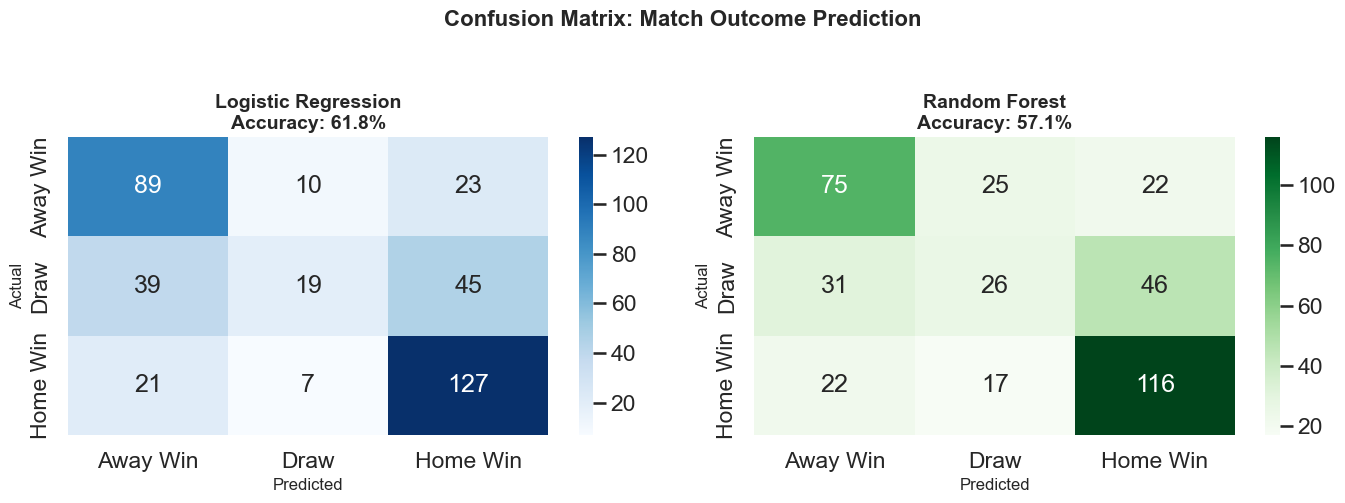

In [19]:
# Confusion Matrix visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Logistic Regression
cm_log = confusion_matrix(y_test_out, y_pred_log)
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_title(f'Logistic Regression\nAccuracy: {accuracy_log:.1%}', fontsize=14, weight='bold')

# Random Forest
cm_rf = confusion_matrix(y_test_out, y_pred_rf_clf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_title(f'Random Forest\nAccuracy: {accuracy_rf_clf:.1%}', fontsize=14, weight='bold')

plt.suptitle('Confusion Matrix: Match Outcome Prediction', fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 3️⃣ Final League Position Prediction

### Statistical Approach
This analysis employs **Linear Regression** and **Random Forest Regression** to forecast end-of-season league positions using mid-season performance metrics (after 19 rounds, approximately halfway through the 38-game season). The temporal aspect makes this a predictive forecasting problem, evaluated using MAE (Mean Absolute Error) to interpret prediction accuracy in terms of league positions.

### Research Question
Can mid-season performance statistics reliably predict where a team will finish in the final standings?

- **Betting markets**: Finding value in long-term position bets

### Variables- **Transfer strategy**: Identifying clubs needing reinforcements

**Dependent Variable (Target):**- **Champions League qualification**: Predicting top 4 finishers

- `final_position` - Final league position (1 = Champion, 20 = Last place)- **Relegation battle forecasting**: Early identification of teams at risk

### Practical Applications

**Independent Variables (Features - Mid-Season Stats):**

- `points` - Total points accumulated (Wins × 3 + Draws × 1)- Which teams are overperforming (lucky) vs genuinely strong?

- `xg_for` - Cumulative Expected Goals created- Do xG-based metrics predict future performance better than current points?

- `xg_against` - Cumulative Expected Goals conceded- Can we identify teams likely to improve/decline in the second half?

- `xg_diff` - Net xG difference (xg_for - xg_against)- How stable are league positions throughout the season?

- `goals_for` - Actual goals scoredThis model helps answer:

- `goals_against` - Actual goals conceded### Analysis Purpose

- `goal_diff` - Goal difference (goals_for - goals_against)

- `ppg` - Points per game (normalized performance metric)4. **xG metrics add value**: Underlying performance reveals over/underperforming teams

3. **Points and PPG as top predictors**: Current standings heavily influence final standings

### Expected Outcomes2. **Low MAE (<3 positions)**: Predictions within 2-3 positions of actual finish
1. **High R² (>0.75)**: Mid-season form strongly indicates final position

In [20]:
# Calculate season aggregates for each team
def calculate_team_season_stats(df, cutoff_round=19):
    """
    Calculate team statistics up to a certain round (mid-season by default).
    """
    results = []
    
    for season in df['season'].unique():
        season_df = df[df['season'] == season]
        
        # Mid-season data (first half)
        mid_season = season_df[season_df['round'] <= cutoff_round]
        
        for team in season_df['team'].unique():
            # Home matches
            home = mid_season[mid_season['team'] == team]
            # Away matches
            away = mid_season[mid_season['opponent'] == team]
            
            # Calculate stats
            xg_for = home['xg'].sum() + away['xga'].sum()
            xg_against = home['xga'].sum() + away['xg'].sum()
            goals_for = home['gf'].sum() + away['ga'].sum()
            goals_against = home['ga'].sum() + away['gf'].sum()
            
            # Points
            home_wins = (home['gf'] > home['ga']).sum()
            home_draws = (home['gf'] == home['ga']).sum()
            away_wins = (away['gf'] < away['ga']).sum()
            away_draws = (away['gf'] == away['ga']).sum()
            points = home_wins * 3 + home_draws + away_wins * 3 + away_draws
            
            matches = len(home) + len(away)
            
            results.append({
                'season': season,
                'team': team,
                'matches': matches,
                'points': points,
                'xg_for': xg_for,
                'xg_against': xg_against,
                'xg_diff': xg_for - xg_against,
                'goals_for': goals_for,
                'goals_against': goals_against,
                'goal_diff': goals_for - goals_against,
                'ppg': points / matches if matches > 0 else 0  # Points per game
            })
    
    return pd.DataFrame(results)

# Calculate mid-season stats
mid_season_stats = calculate_team_season_stats(df, cutoff_round=19)
print(f"Mid-season stats calculated for {len(mid_season_stats)} team-seasons")
mid_season_stats.head(10)

Mid-season stats calculated for 100 team-seasons


,season,team,matches,points,xg_for,xg_against,xg_diff,goals_for,goals_against,goal_diff,ppg
0,2024,Atalanta,19,42,35.1,18.1,17.0,44,21,23,2.210526
1,2024,Lazio,19,35,30.0,20.0,10.0,33,27,6,1.842105
2,2024,Torino,19,21,18.1,24.5,-6.4,19,24,-5,1.105263
3,2024,Udinese,19,25,17.3,26.5,-9.2,23,28,-5,1.315789
4,2024,Empoli,19,20,15.7,24.6,-8.9,18,22,-4,1.052632
5,2024,Venezia,19,14,18.0,30.6,-12.6,18,32,-14,0.736842
6,2024,Milan,19,30,30.3,20.9,9.4,29,20,9,1.578947
7,2024,Bologna,19,32,24.6,20.2,4.4,29,24,5,1.684211
8,2024,Napoli,19,44,27.7,15.6,12.1,30,12,18,2.315789
9,2024,Como,19,18,22.1,21.0,1.1,21,32,-11,0.947368


In [21]:
# Calculate final positions for each team-season
def calculate_final_positions(df):
    """
    Calculate final league position for each team in each season.
    """
    final_positions = []
    
    for season in df['season'].unique():
        season_df = df[df['season'] == season]
        
        # Calculate final points for all teams
        teams_stats = {}
        all_teams = pd.concat([season_df['team'], season_df['opponent']]).unique()
        
        for team in all_teams:
            home = season_df[season_df['team'] == team]
            away = season_df[season_df['opponent'] == team]
            
            home_wins = (home['gf'] > home['ga']).sum()
            home_draws = (home['gf'] == home['ga']).sum()
            away_wins = (away['gf'] < away['ga']).sum()
            away_draws = (away['gf'] == away['ga']).sum()
            
            points = home_wins * 3 + home_draws + away_wins * 3 + away_draws
            gd = (home['gf'].sum() + away['ga'].sum()) - (home['ga'].sum() + away['gf'].sum())
            
            teams_stats[team] = {'points': points, 'gd': gd}
        
        # Sort by points, then goal difference
        sorted_teams = sorted(teams_stats.items(), 
                             key=lambda x: (x[1]['points'], x[1]['gd']), 
                             reverse=True)
        
        for position, (team, stats) in enumerate(sorted_teams, 1):
            final_positions.append({
                'season': season,
                'team': team,
                'final_position': position,
                'final_points': stats['points']
            })
    
    return pd.DataFrame(final_positions)

final_positions = calculate_final_positions(df)
print(f"Final positions calculated for {len(final_positions)} team-seasons")
final_positions.head(10)

Final positions calculated for 100 team-seasons


,season,team,final_position,final_points
0,2024,Napoli,1,82
1,2024,Internazionale,2,81
2,2024,Atalanta,3,74
3,2024,Juventus,4,70
4,2024,Roma,5,69
5,2024,Fiorentina,6,65
6,2024,Lazio,7,65
7,2024,Milan,8,63
8,2024,Bologna,9,62
9,2024,Como,10,49


In [22]:
# Merge mid-season stats with final positions
position_data = mid_season_stats.merge(final_positions, on=['season', 'team'])
print(f"Combined dataset: {len(position_data)} team-seasons")
position_data.head()

Combined dataset: 100 team-seasons


,season,team,matches,points,xg_for,xg_against,xg_diff,goals_for,goals_against,goal_diff,ppg,final_position,final_points
0,2024,Atalanta,19,42,35.1,18.1,17.0,44,21,23,2.210526,3,74
1,2024,Lazio,19,35,30.0,20.0,10.0,33,27,6,1.842105,7,65
2,2024,Torino,19,21,18.1,24.5,-6.4,19,24,-5,1.105263,11,44
3,2024,Udinese,19,25,17.3,26.5,-9.2,23,28,-5,1.315789,12,44
4,2024,Empoli,19,20,15.7,24.6,-8.9,18,22,-4,1.052632,18,31


In [23]:
# Prepare features for position prediction
position_features = ['points', 'xg_for', 'xg_against', 'xg_diff', 'goals_for', 'goals_against', 'goal_diff', 'ppg']

X_position = position_data[position_features].copy()
y_position = position_data['final_position'].copy()

# Split data
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(
    X_position, y_position, test_size=0.2, random_state=42
)

print(f"Training set: {len(X_train_pos)}")
print(f"Test set: {len(X_test_pos)}")

Training set: 80
Test set: 20


In [24]:
# Train Linear Regression for position prediction
lr_pos = LinearRegression()
lr_pos.fit(X_train_pos, y_train_pos)

# Predictions
y_pred_pos_lr = lr_pos.predict(X_test_pos)

# Evaluate
mse_pos_lr = mean_squared_error(y_test_pos, y_pred_pos_lr)
rmse_pos_lr = np.sqrt(mse_pos_lr)
mae_pos_lr = mean_absolute_error(y_test_pos, y_pred_pos_lr)
r2_pos_lr = r2_score(y_test_pos, y_pred_pos_lr)

print("="*60)
print("Linear Regression - Final Position Prediction")
print("(Using Mid-Season Stats to Predict Final Position)")
print("="*60)
print(f"Mean Squared Error:        {mse_pos_lr:.4f}")
print(f"Root Mean Squared Error:   {rmse_pos_lr:.4f}")
print(f"Mean Absolute Error:       {mae_pos_lr:.4f}")
print(f"R² Score:                  {r2_pos_lr:.4f}")
print("="*60)
print(f"\nInterpretation: On average, predictions are off by {mae_pos_lr:.1f} positions")

Linear Regression - Final Position Prediction
(Using Mid-Season Stats to Predict Final Position)
Mean Squared Error:        7.2097
Root Mean Squared Error:   2.6851
Mean Absolute Error:       2.2445
R² Score:                  0.8145

Interpretation: On average, predictions are off by 2.2 positions


In [25]:
# Train Random Forest for position prediction
rf_pos = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_pos.fit(X_train_pos, y_train_pos)

# Predictions
y_pred_pos_rf = rf_pos.predict(X_test_pos)

# Evaluate
mse_pos_rf = mean_squared_error(y_test_pos, y_pred_pos_rf)
rmse_pos_rf = np.sqrt(mse_pos_rf)
mae_pos_rf = mean_absolute_error(y_test_pos, y_pred_pos_rf)
r2_pos_rf = r2_score(y_test_pos, y_pred_pos_rf)

print("="*60)
print("Random Forest - Final Position Prediction")
print("="*60)
print(f"Mean Squared Error:        {mse_pos_rf:.4f}")
print(f"Root Mean Squared Error:   {rmse_pos_rf:.4f}")
print(f"Mean Absolute Error:       {mae_pos_rf:.4f}")
print(f"R² Score:                  {r2_pos_rf:.4f}")
print("="*60)

Random Forest - Final Position Prediction
Mean Squared Error:        8.0426
Root Mean Squared Error:   2.8359
Mean Absolute Error:       2.1855
R² Score:                  0.7930


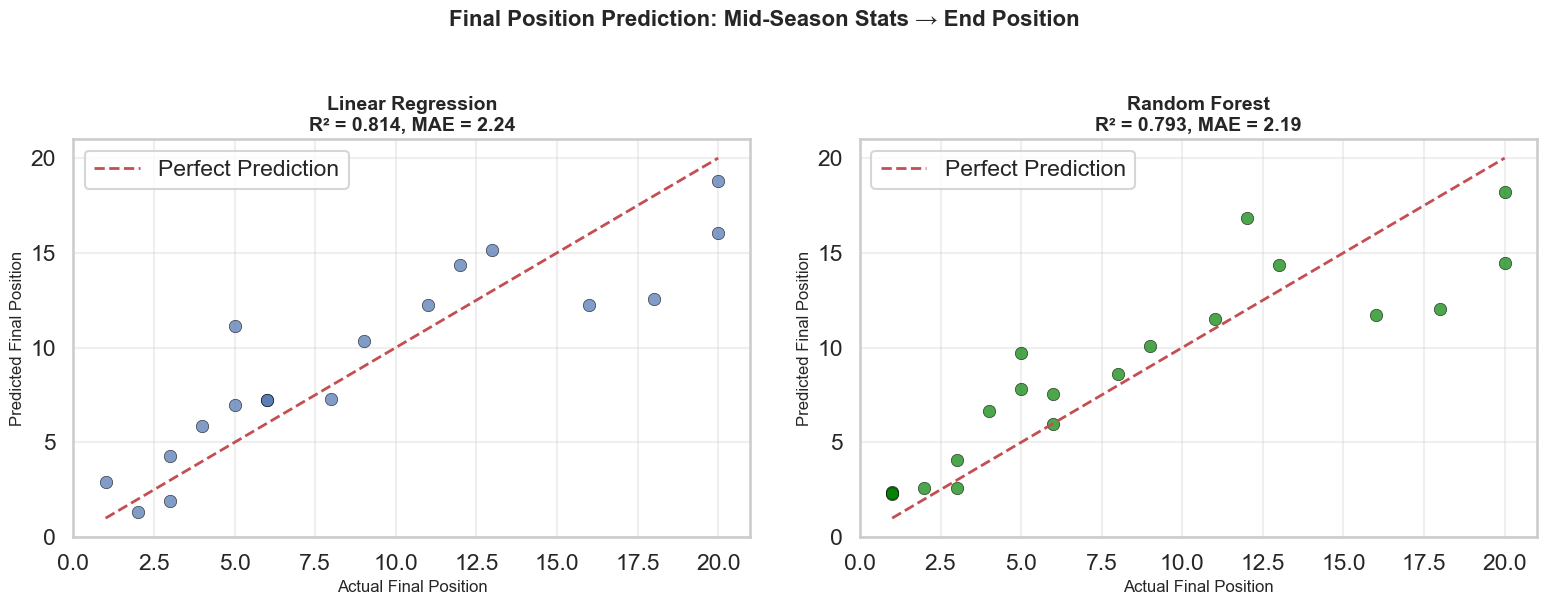

In [26]:
# Visualization: Predicted vs Actual Position
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Linear Regression
axes[0].scatter(y_test_pos, y_pred_pos_lr, alpha=0.7, edgecolors='black', linewidth=0.5, s=80)
axes[0].plot([1, 20], [1, 20], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Final Position', fontsize=12)
axes[0].set_ylabel('Predicted Final Position', fontsize=12)
axes[0].set_title(f'Linear Regression\nR² = {r2_pos_lr:.3f}, MAE = {mae_pos_lr:.2f}', fontsize=14, weight='bold')
axes[0].set_xlim(0, 21)
axes[0].set_ylim(0, 21)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Random Forest
axes[1].scatter(y_test_pos, y_pred_pos_rf, alpha=0.7, edgecolors='black', linewidth=0.5, s=80, color='green')
axes[1].plot([1, 20], [1, 20], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Final Position', fontsize=12)
axes[1].set_ylabel('Predicted Final Position', fontsize=12)
axes[1].set_title(f'Random Forest\nR² = {r2_pos_rf:.3f}, MAE = {mae_pos_rf:.2f}', fontsize=14, weight='bold')
axes[1].set_xlim(0, 21)
axes[1].set_ylim(0, 21)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.suptitle('Final Position Prediction: Mid-Season Stats → End Position', fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.show()

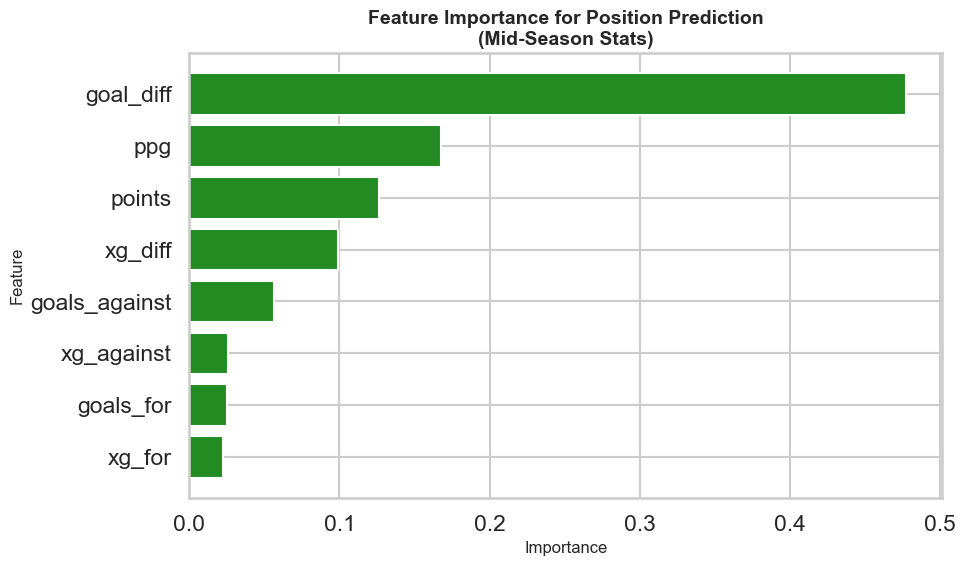


Feature Importance Ranking:
  goal_diff      : 0.4774
  ppg            : 0.1674
  points         : 0.1265
  xg_diff        : 0.0989
  goals_against  : 0.0566
  xg_against     : 0.0260
  goals_for      : 0.0250
  xg_for         : 0.0222


In [27]:
# Feature importance for position prediction
pos_importance = pd.DataFrame({
    'feature': position_features,
    'importance': rf_pos.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(pos_importance['feature'], pos_importance['importance'], color='forestgreen')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance for Position Prediction\n(Mid-Season Stats)', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
for _, row in pos_importance.sort_values('importance', ascending=False).iterrows():
    print(f"  {row['feature']:15s}: {row['importance']:.4f}")

---
## 📊 Model Comparison Summary

In [28]:
# Summary table of all models
summary_data = {
    'Model': [
        'Goals Prediction (Linear)', 
        'Goals Prediction (RF)',
        'Outcome Prediction (Logistic)',
        'Outcome Prediction (RF)',
        'Position Prediction (Linear)',
        'Position Prediction (RF)'
    ],
    'Task Type': [
        'Regression', 'Regression',
        'Classification', 'Classification',
        'Regression', 'Regression'
    ],
    'Primary Metric': [
        f'R² = {r2_lr:.3f}', f'R² = {r2_rf:.3f}',
        f'Accuracy = {accuracy_log:.1%}', f'Accuracy = {accuracy_rf_clf:.1%}',
        f'R² = {r2_pos_lr:.3f}', f'R² = {r2_pos_rf:.3f}'
    ],
    'Error Metric': [
        f'RMSE = {rmse_lr:.3f}', f'RMSE = {rmse_rf:.3f}',
        '-', '-',
        f'MAE = {mae_pos_lr:.2f} positions', f'MAE = {mae_pos_rf:.2f} positions'
    ]
}

summary_df = pd.DataFrame(summary_data)
print("="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

MODEL COMPARISON SUMMARY
                        Model      Task Type   Primary Metric         Error Metric
    Goals Prediction (Linear)     Regression       R² = 0.462         RMSE = 0.876
        Goals Prediction (RF)     Regression       R² = 0.377         RMSE = 0.943
Outcome Prediction (Logistic) Classification Accuracy = 61.8%                    -
      Outcome Prediction (RF) Classification Accuracy = 57.1%                    -
 Position Prediction (Linear)     Regression       R² = 0.814 MAE = 2.24 positions
     Position Prediction (RF)     Regression       R² = 0.793 MAE = 2.19 positions


---
## 🎯 Key Findings

### Goals Prediction
- **xG is the strongest predictor** of actual goals scored
- Linear regression captures most of the variance explained by xG
- Random Forest captures non-linear relationships but may overfit

### Match Outcome Prediction
- xG differential is the most important feature for predicting outcomes
- Draws are hardest to predict (inherently difficult)
- Model accuracy significantly better than random guessing (33%)

### Position Prediction
- Mid-season performance is highly predictive of final position
- Points and goal difference are key predictors
- xG-based metrics add predictive value beyond actual results

---